# Calculating Claim Statistics for a Subset of Patents using the Google Patents Public Datasets on BigQuery.

-----------------

Copyright 2017 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0
     
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


## Overview

Imagine you're analyzing a subset of patents and want to do some text analysis of the first independent claim. To do this, you'd need to be able to join your list of patent publication numbers with a dataset containing the patent text. Additionally, you'd need a method to extract the first claim from the rest of the claims. This notebook is a demonstration of one method to perform this analysis using python, BigQuery, and Google's [new public dataset on patents](https://cloud.google.com/bigquery/public-data/google-patents). 

What follows is a walkthrough of how to extract the first claim from a set of US Patent publications and run a few summary statistics against the first claim. The set of patents we analyze in this notebook is a random sample of 20,000 patents filed between 1995 and present in the G06F Cooperative Patent Classification (CPC) code, however this analysis could be repeated for any arbitrary list of patents of interest. 

The steps we'll use to get there are:
1. Create a new BigQuery "dataset" where we can store our results. For anyone new to bigquery, check out [the quickstart guide](https://cloud.google.com/bigquery/quickstart-web-ui).
2. Upload a list of patent publications we wish to analyze.
3. Join this list with Google's public patent data.
4. Extract the first claim using regular expressions and BigQuery User Defined Functions.
5. Calculate summary statistics about the first claims and plot results over time.


## Pre-requisites
- A google cloud account with access to BigQuery. If you don't have an account yet, [this page](https://cloud.google.com/free/) will guide you through the process to get started with an account and access the free tier of services.
- Basic knowledge of how to run a query using the BigQuery web UI. If you're new to this, check out [this page](https://cloud.google.com/bigquery/public-data/) for a quick intro.
- Basic knowledge of [pandas dataframes](https://pandas.pydata.org/pandas-docs/stable/10min.html) and python programming.
- A few python packages (pandas, seaborn, matplotlib and google-api-python-client.

In [1]:
from __future__ import print_function
from google.cloud import bigquery
import pandas as pd
import matplotlib.pylab as plt
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
import uuid
import time
# Variables to be used throughout the notebook, replace with your project
# and desired dataset name.
PROJECT_ID = 'clean-phoenix-308519'
DEST_DATASET = 'claims_analysis62'

# Create a python client we can use for executing table creation queries
client = bigquery.Client(project=PROJECT_ID)
# Create an HTTP client for additional functionality.
credentials = GoogleCredentials.get_application_default()
http_client = discovery.build('bigquery', 'v2', credentials=credentials)

In [2]:
%matplotlib inline

## 1. Create a new BigQuery Dataset

During this analysis, we're going to be leveraging BigQuery to do most of the computation and we'll store our results in tables in BigQuery. To organize this, we'll need a new dataset to work with. We'll use the API to create a new dataset. For more on working with the BigQuery python client library, see [this page](https://cloud.google.com/bigquery/docs/reference/libraries#client-libraries-install-python).

In [3]:
dataset_ref = client.dataset(DEST_DATASET)
dataset = bigquery.Dataset(dataset_ref)
client.create_dataset(dataset)
print('Dataset {} created.'.format(dataset.dataset_id))

Dataset claims_analysis62 created.


## 2. Upload a list of Publication Numbers for analysis

 In this hypothetical example, we are planning to inspect the first claims from a set of patents. To do this, we need to get our list of publication numbers into BigQuery. Since this is just an example, we're going to use a random sample of 20k G06F patents we have saved to a CSV file and added to this repo, but this could be any set of patents you're interested in. We'll leverage [pandas "to_gbq" method]("https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_gbq.html") to simplify this. (Note, you could also do this from the [web UI or API.]("https://cloud.google.com/bigquery/loading-data") )


The steps we need to complete are:

1. Load a csv containing publication numbers.
2. Store these records in a new table in our BigQuery dataset. 

In [4]:
# Load a list of patents from disk
df = pd.read_csv('./data/20k_G_and_H_publication_numbers.csv')
df.head(5)

,publication_number
0,US-20040119648-A1
1,US-20040222923-A1
2,US-20050113133-A1
3,US-20050259013-A1
4,US-5977928-A


In [5]:
# Upload these to our dataset on BigQuery.
pubs_table = 'claim_text_publications'
full_table_path = '{}.{}'.format(DEST_DATASET, pubs_table)
df.to_gbq(destination_table=full_table_path,
          project_id=PROJECT_ID,
          if_exists='replace')

1it [00:08,  8.99s/it]


## 3. Join our uploaded list of publications with the patents-public-data on BigQuery to get the text of the claims, priority year, and classification code at the 4 digit level. 

In the next section, we'll begin using the public patent data which is available on Big Query. Among numerous other fields, this table includes the text of the patent claims, the CPC code, and priority date of the patent claims. Because BigQuery doesn't have a "create table as" syntax, we've created a function to handle constuction of a call to the BigQuery python API. This is simply a helper function, which takes a query and produces a table. This can also easily by done [using the web UI](https://cloud.google.com/bigquery/docs/tables).

The steps to be completed are:

1. Write a query which produces a 4 column table: publication number, priority year, CPC code (split at 4 digits), and the full text of the claims. 
2. Run this query, and write the results to a table in our project/dataset.

In [6]:
def create_table_as(query_string, dest_table, project_id=PROJECT_ID, dest_dataset=DEST_DATASET,
                    http_client=http_client, overwrite=True, use_legacy_sql=False):
  """Simulates a 'create table as' statement in BigQuery.

  Args:
    query_string: A string query that produces rows of data.
    dest_table: string table name to use for storing results.
    project_id: string project id to use for running query and storing results.
    dest_dataset: String name of dataset to use for storing results.
    http_client: An http client for use in inserting the BigQuery Job.
    overwrite: Should new data be appended to existing data or overwritten?
    use_legacy_sql: Defaults to standard_sql, but option to use legacy.

  Raises:
    Exception: If the BigQuery job finshes with an error, a general Exception is raised
    with the error message from BigQuery included.
  """
  write_disposition = 'WRITE_TRUNCATE'
  if not overwrite:
    write_disposition = 'WRITE_APPEND'
  config = {
      'kind': 'bigquery#job',
      'projectId': str(uuid.uuid4()),
      'configuration': {
          'query': {
              'query': query_string,
              'destinationTable': {
                  'projectId': project_id,
                  'datasetId': dest_dataset,
                  'tableId': dest_table
              },
              'createDisposition': 'CREATE_IF_NEEDED',
              'writeDisposition': write_disposition,
              'useLegacySql': use_legacy_sql
          }
      }
  }
  done = False
  request = http_client.jobs().insert(
      projectId=project_id, body=config).execute()
  job_id = request['jobReference']['jobId']
  while not done:
    jobs = http_client.jobs().list(projectId=project_id).execute()
    matches = [j for j in jobs['jobs'] if j['jobReference']['jobId'] == job_id]
    if matches[0]['state'] == 'DONE':
      if matches[0].get('errorResult'):
        raise Exception(
            'Create table failed: {}'.format(matches[0]['errorResult']))
      done = True
    print('Job still running...')
    time.sleep(5)

  print('Created table {}.'.format(dest_table))

In [7]:
query = """
#standardSQL

WITH P AS (
  SELECT 
  DISTINCT publication_number, 
  substr(cpc.code, 1,4) cpc4,
  floor(priority_date / 10000) priority_yr
  FROM `patents-public-data.patents.publications`,
  unnest(cpc) as cpc
  WHERE country_code = 'US'
  AND floor(priority_date / 10000) >= 1995
  AND country_code = 'US'
)

SELECT 
P.publication_number,
P.priority_yr,
P.cpc4,
claims.text
FROM `patents-public-data.patents.publications` as pubs,
UNNEST(claims_localized) as claims
JOIN P 
  ON P.publication_number = pubs.publication_number
JOIN `{}.{}.{}` my_pubs
  ON pubs.publication_number = my_pubs.publication_number
WHERE claims.language = 'en'
""".format(PROJECT_ID, DEST_DATASET, pubs_table)
create_table_as(query, '20k_G06F_pubs_after_1994')

Job still running...
Job still running...
Job still running...
Created table 20k_G06F_pubs_after_1994.


### Lets inspect the contents of this new table we've created

We've now written these results to a table, lets take a look at the output. First, we'll pull down a random sample of 500 rows using a BigQuery trick for selecting a random sample (see below). We'll get the data with a handy pandas function, ["read_gbq"](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_gbq.html). Once we get the data in memory, let's look at the distribution of priority years and inspect a few example claims. 


- To get a random sample of roughly n_rows, we can simply include a statement in our where clause that looks like:

   ```
   where rand() < n_rows / total_rows_in_table```

- Since we have about 20k rows and we want a sample of about 500, this becomes:
  ```
  where rand() < 500 / 20000```

In [8]:
query = """
SELECT *
FROM `{}.{}.20k_G06F_pubs_after_1994`
""".format(PROJECT_ID, DEST_DATASET)
df = pd.read_gbq(query, project_id=PROJECT_ID, dialect='standard')

In [9]:
# Quick visualization of the first 5 rows
df.head(n=48)

,publication_number,priority_yr,cpc4,text
0,US-6054961-A,1997.0,H01Q,We claim: \n \n 1. A dual band anten...
1,US-6343208-B1,1998.0,H01Q,What is claimed is: \n \n 1. A comm...
2,US-6166694-A,1998.0,H04B,What is claimed is: \n \n 1. A commu...
3,US-6166694-A,1998.0,H01Q,What is claimed is: \n \n 1. A commu...
4,US-6343208-B1,1998.0,H04B,What is claimed is: \n \n 1. A comm...
5,US-5977928-A,1998.0,H01Q,What is claimed is: \n \n 1. A commu...
6,US-6408190-B1,1999.0,H01Q,What is claimed is: \n \n 1. A comm...
7,US-6408190-B1,1999.0,H04B,What is claimed is: \n \n 1. A comm...
8,US-7158819-B1,2000.0,H01Q,1. A multi-band antenna apparatus comprising:\...
9,US-7439923-B2,2001.0,H01Q,1. A multiband antenna comprising:\n a multile...


In [10]:
# Do we have a mix of data from 1995-present?
df.priority_yr.value_counts().sort_index()

1997.0    1
1998.0    5
1999.0    2
2000.0    1
2001.0    1
2002.0    4
2003.0    3
2007.0    1
2009.0    1
2010.0    4
2011.0    2
2012.0    5
2013.0    1
2014.0    2
2015.0    2
Name: priority_yr, dtype: int64

In [11]:
# What do the claims look like?
test = []
for claim in df.sample(2).text:
  print('-----' * 5, '\n\nEXAMPLE CLAIM: \n\n', claim[:2000])
  #test = claim[:2000]

------------------------- 

EXAMPLE CLAIM: 

 What is claimed is:  
     
       1. A communication device for use in a radio communication system, said device comprising: 
       a microphone opening for allowing the communication device to receive auditory information from a user;  
       a speaker opening for allowing the communication device to transmit auditory information to said user;  
       a keypad; and  
       a semi built-in multiple band printed antenna, said antenna comprising:  
       a first patch part located on a printed circuit board (PCB) within said communication device and tuned to a first frequency band,  
       a second patch part located outside said PCB and tuned to a second frequency band different from said first frequency band, and  
       at least one slot formed in each of said first and second patch parts.  
     
     
       2. The communication device of  claim 1  wherein said first frequency band is a lower frequency band and said second freque

## Extract the First Claims Using A UDF in Big Query

Since we have the full claim above, we need a way to parse out just the first claim. BigQuery has [User Defined Functions (UDF's)](https://cloud.google.com/bigquery/docs/reference/standard-sql/user-defined-functions) which let the user pass columns through some arbitrary function. In our case, we need some logic to parse the claims and split after the first claim has ended. In most cases we can simply split on the text "1." but there are also cases where the text is not so cleanly formatted. The UDF below shows and example of using javascript regular expressions to parse the first claim.

The basic logic is to work down the following options, returning the first positive match:

1. Try to split on '2.' or '2 .'.
2. Find the first mention of 'claim 1' and split there.
3. Handle canceled claims by finding the word canceled and determining which claim was the first non-canceled claim.
4. Look for a sentence beginning with "The" - split and return the first half.
5. Finally, just return the first 2000 characters. 

In [12]:
# The JS script to run against the text of our claims.
js = r"""

// Regex to find a period followed by any number of spaces and '2.' or '2 .'
var pattern = new RegExp(/[.][\\s]+[2][\\s]*[.]/, 'g');
if (pattern.test(text)) {
  return text.split(pattern)[0];
}

// If none of the above worked, try to find a reference to claim 1.
if (text.indexOf('claim 1 ') > -1) {
  return text.split('claim 1 ')[0];
}

// Look for claim cancelations and return first non-canceled claim
text = text.replace(/canceled/i, 'canceled')
text = text.replace(/cancelled/i, 'canceled')
if (text.indexOf('(canceled)') > -1) {
	text = text.split('(canceled)')
	canceled = text[0];
	not_canceled = text[1];
	// Determine first non-cancelled claim
	if (canceled.indexOf('-') > -1 ) {
		next_claim = parseInt(canceled.split('-')[1]) + 1
	}
	else {
		next_claim = 2;
	}
	// Split on next_claim + 1
	return not_canceled.split(next_claim + 1)[0].trim();
}


// If none of the above worked, try to find a sentence starting with 'The'
// This should only happen after claim 1 has been defined.
if (text.indexOf(' The ') > -1) {
  return text.split(' The ')[0];
}

// if none of the above worked return the first 2000 characters. 
return text.slice(0,2000);
"""

In [13]:
# Insert the JS code above into this string, and pass it to Big Query
query = r'''
#standardSQL
CREATE TEMPORARY FUNCTION get_first_claim(text STRING)
RETURNS STRING
LANGUAGE js AS """
{}
"""; 

 
SELECT 
pubs.*, 
get_first_claim(text) first_claim
FROM `{}.{}.20k_G06F_pubs_after_1994` pubs
'''.format(js, PROJECT_ID, DEST_DATASET)
CLAIM_TEXT_TABLE = '20k_G06F_pubs_after_1994_split_first_claim'
create_table_as(query, CLAIM_TEXT_TABLE)

Job still running...
Job still running...
Created table 20k_G06F_pubs_after_1994_split_first_claim.


In [14]:
query = """
SELECT * FROM `{}.{}.{}` WHERE RAND() < 50/50 
""".format(PROJECT_ID, DEST_DATASET, CLAIM_TEXT_TABLE)
df = pd.read_gbq(query, project_id=PROJECT_ID, dialect='standard')

## Let's See how that UDF Performed

One way to test the UDF would be to run a query in bigquery against an example we can test. For example:

```SELECT get_first_claim("1. test claim 1 2. test claim 2");```

We can also run this claim against real data and pull down a sample, which is shown below. We've now created a new table which has both the full claims text as well as our extracted first claim. Lets compare a few to see how well it worked.

In [15]:
for idx, row in df.sample(30).iterrows():
  print('------' * 10, '\nORIGINAL CLAIM TEXT:\n', '------' * 10)
  print(row.text[:8000], '\n')
  print('------' * 10, '\nRESULT AFTER PARSING WITH UDF:\n', '------' * 10)
  print(row.first_claim, '...\n\n')
  test.append(row.first_claim)

------------------------------------------------------------ 
ORIGINAL CLAIM TEXT:
 ------------------------------------------------------------
What is claimed is: 
     
       1. An ultra-wideband cellular, dual-polarization dual-band basestation antenna having a low band and a high band suitable for cellular communications, the dual-band antenna comprising:
 at least one low band radiator having a crossed dipole configuration including a vertical dipole with two dipole arms and a horizontal dipole with two dipole arms located above a vertically-extending groundplane, forming clear regions on the groundplane, to provide vertical and horizontal polarization; 
 a plurality of high band radiators each comprising a crossed dipole and inclined at 45° so as to radiate slant polarization, the high band radiators located within the clear regions on the groundplane of the dual-band antenna, 
 wherein the at least one low band radiator having the crossed dipole configuration defines four quad

# Lastly, lets use BigQuery to calculate some statistics about the first claim.

From the start, the goal here was to compute some summary statistics about claims for a specific set of patents. Namely, we're interested to see if the number of elements, character counts, or word counts have varied over time. 

-----------------

## Average Word Count by Year

In [16]:
# Average Word Count by Year:
query = r"""
#standardSQL
with words as (
  SELECT 
  publication_number,
  priority_yr,
  SPLIT(REGEXP_REPLACE(first_claim, r'\s{2,}', ''), ' ') word
  FROM `%s.%s.%s`
)

SELECT 
  priority_yr, 
  avg(num_words) avg_word_cnt
FROM (
  SELECT
  publication_number,
  priority_yr,
  count(*) as num_words
  from words, unnest(word)
  group by 1,2
)
GROUP BY 1
ORDER BY 1
""" %(PROJECT_ID, DEST_DATASET, CLAIM_TEXT_TABLE)
df = pd.read_gbq(query, project_id=PROJECT_ID, dialect='standard')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


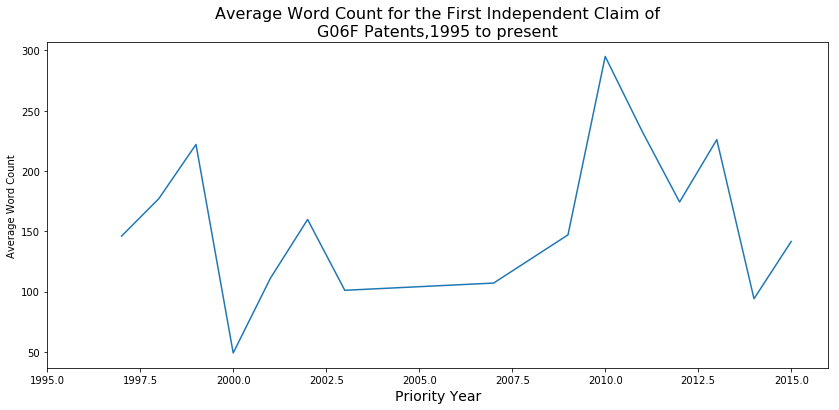

In [17]:
plt.figure(figsize=(14, 6))
plt.plot(df.priority_yr, df.avg_word_cnt)
plt.xlabel('Priority Year', fontsize=14)
plt.xlim(1995, 2016)
plt.ylabel('Average Word Count')
plt.title('Average Word Count for the First Independent Claim of\nG06F Patents,'
          '1995 to present', fontsize=16)
plt.show()

## Average Number of Elements by Year

In [18]:
query = """
#standardSQL
with elements as (
  SELECT 
  publication_number,
  priority_yr,
  SPLIT(first_claim, ';') element
  FROM `%s.%s.%s`
)

SELECT 
  priority_yr, 
  avg(num_elements) avg_element_cnt
FROM (
  SELECT
  publication_number,
  priority_yr,
  count(*) as num_elements
  from elements, unnest(element)
  group by 1,2
)
GROUP BY 1
ORDER BY 1
""" %(PROJECT_ID, DEST_DATASET, CLAIM_TEXT_TABLE)
df = pd.read_gbq(query, project_id=PROJECT_ID, dialect='standard')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


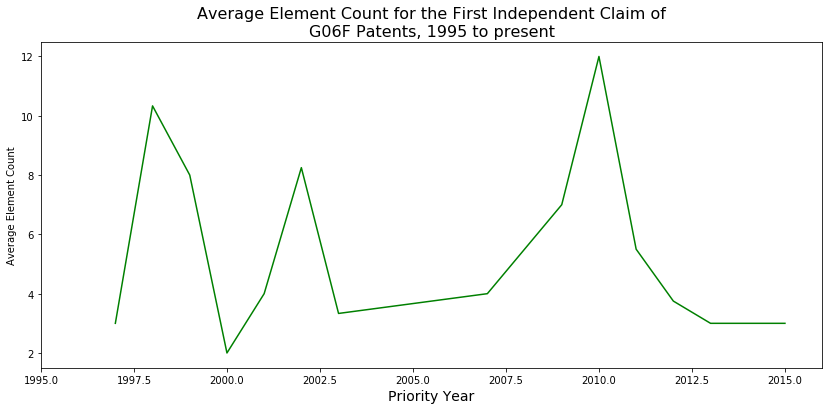

In [19]:
plt.figure(figsize=(14, 6))
plt.plot(df.priority_yr, df.avg_element_cnt, color='g')
plt.xlabel('Priority Year', fontsize=14)
plt.xlim(1995, 2016)
plt.ylabel('Average Element Count')
plt.title('Average Element Count for the First Independent Claim of\n'
          'G06F Patents, 1995 to present', fontsize=16)
plt.show()

In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
max_length = 128  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 2

# Labels in our dataset.
labels = ["contradiction", "entailment", "neutral"]

!curl -LO https://raw.githubusercontent.com/MohamadMerchant/SNLI/master/data.tar.gz
!tar -xvzf data.tar.gz

# There are more than 550k samples in total; we will use 100k for this example.
train_df = pd.read_csv("SNLI_Corpus/snli_1.0_train.csv", nrows=100000)
valid_df = pd.read_csv("SNLI_Corpus/snli_1.0_dev.csv")
test_df = pd.read_csv("SNLI_Corpus/snli_1.0_test.csv")

# Shape of the data
print(f"Total train samples : {train_df.shape[0]}")
print(f"Total validation samples: {valid_df.shape[0]}")
print(f"Total test samples: {valid_df.shape[0]}")

print(f"Sentence1: {train_df.loc[1, 'sentence1']}")
print(f"Sentence2: {train_df.loc[1, 'sentence2']}")
print(f"Similarity: {train_df.loc[1, 'similarity']}")

# We have some NaN entries in our train data, we will simply drop them.
print("Number of missing values")
print(train_df.isnull().sum())
train_df.dropna(axis=0, inplace=True)

print("Train Target Distribution")
print(train_df.similarity.value_counts())

print("Validation Target Distribution")
print(valid_df.similarity.value_counts())
train_df = (
    train_df[train_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)
valid_df = (
    valid_df[valid_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

train_df["label"] = train_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_train = tf.keras.utils.to_categorical(train_df.label, num_classes=3)

valid_df["label"] = valid_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_val = tf.keras.utils.to_categorical(valid_df.label, num_classes=3)

test_df["label"] = test_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_test = tf.keras.utils.to_categorical(test_df.label, num_classes=3)


class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)

# Create the model under a distribution strategy scope.
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    sequence_output, pooled_output = bert_model(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(sequence_output)
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(3, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )


print(f"Strategy: {strategy}")
model.summary()

train_data = BertSemanticDataGenerator(
    train_df[["sentence1", "sentence2"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)
valid_data = BertSemanticDataGenerator(
    valid_df[["sentence1", "sentence2"]].values.astype("str"),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)

history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
)

# Unfreeze the bert_model.
bert_model.trainable = True
# Recompile the model to make the change effective.
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
)

test_data = BertSemanticDataGenerator(
    test_df[["sentence1", "sentence2"]].values.astype("str"),
    y_test,
    batch_size=batch_size,
    shuffle=False,
)
model.evaluate(test_data, verbose=1)

def check_similarity(sentence1, sentence2):
    sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
    test_data = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

    proba = model.predict(test_data)[0]
    idx = np.argmax(proba)
    proba = f"{proba[idx]: .2f}%"
    pred = labels[idx]
    return pred, proba

sentence1 = "Two women are observing something together."
sentence2 = "Two women are standing with their eyes closed."
check_similarity(sentence1, sentence2)

sentence1 = "A smiling costumed woman is holding an umbrella"
sentence2 = "A happy woman in a fairy costume holds an umbrella"
check_similarity(sentence1, sentence2)

sentence1 = "A soccer game with multiple males playing"
sentence2 = "Some men are playing a sport"
check_similarity(sentence1, sentence2)


'''
print("These are the claims: \n")
print(*test, sep = "\n.....................\n")
'''

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 12 11.1M   12 1384k    0     0  3401k      0  0:00:03 --:--:--  0:00:03 3540k
 42 11.1M   42 4856k    0     0  3451k      0  0:00:03  0:00:01  0:00:02 3491k
 71 11.1M   71 8136k    0     0  3380k      0  0:00:03  0:00:02  0:00:01 3402k
100 11.1M  100 11.1M    0     0  3474k      0  0:00:03  0:00:03 --:--:-- 3491k
x SNLI_Corpus/
x SNLI_Corpus/snli_1.0_dev.csv
x SNLI_Corpus/snli_1.0_train.csv
x SNLI_Corpus/snli_1.0_test.csv


Total train samples : 100000
Total validation samples: 10000
Total test samples: 10000
Sentence1: A person on a horse jumps over a broken down airplane.
Sentence2: A person is at a diner, ordering an omelette.
Similarity: contradiction
Number of missing values
similarity    0
sentence1     0
sentence2     3
dtype: int64
Train Target Distribution
entailment       33384
contradiction    33310
neutral          33193
-                  110
Name: similarity, dtype: int64
Validation Target Distribution
entailment       3329
contradiction    3278
neutral          3235
-                 158
Name: similarity, dtype: int64
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x00000245CBCC6DA0>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param

KeyboardInterrupt: 